In [9]:
import numpy as np
import pandas as pd
import re, pickle, os
import tensorflow as tf
import matplotlib.pyplot as plt
from scrape import get_entire_web_google_results

# PART 01

### CONCLUSION GENERATION

In [10]:
def clean_dataset(file_dir):
    df = None
    for file in os.listdir(file_dir):
        if file.endswith(".csv"):
            if df is None:
                df = pd.read_csv(file_dir + file)
                df = df[['Paragraph', 'Conclusion']]
                df = df.dropna()
            else:
                df = df.append(pd.read_csv(file_dir + file))
    
    df = df.dropna(how='any', axis=0)
    df['Paragraph'] = df['Paragraph'].apply(lambda x : x.lower().strip())
    df['Conclusion'] = df['Conclusion'].apply(lambda x : 'sostok '+ x + ' eostok')

    paragraphs = df['Paragraph'].tolist()
    conclusions = df['Conclusion'].tolist()

    return paragraphs, conclusions

def plot_token_length_distribution(paragraphs, conclusions):
    paragraph_lengths = [len(paragraph.split()) for paragraph in paragraphs]
    conclusion_lengths = [len(conclusion.split()) for conclusion in conclusions]

    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.hist(paragraph_lengths, bins=50)
    plt.xlabel('paragraph Length')
    plt.ylabel('Number of paragraphs')
    plt.title('paragraph Length Distribution')

    plt.subplot(1, 2, 2)
    plt.hist(conclusion_lengths, bins=50)
    plt.xlabel('conclusion Length')
    plt.ylabel('Number of conclusions')
    plt.title('conclusion Length Distribution')

    plt.show()

    b = [i for i in range(90,100)] 
    for i in b:  
        print(i,'th percentile [paragraphS] is ', np.percentile(paragraph_lengths, i))

    print('\n')

    for i in b:
        print(i,'th percentile [conclusions] is ', np.percentile(conclusion_lengths, i))

def get_tokenizer(
                paragraphs, 
                conclusions,
                save_path1,
                save_path2
                ):

    tokenizer1 = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer1.fit_on_texts(paragraphs)

    with open(save_path1, 'wb') as handle:
        pickle.dump(tokenizer1, handle, protocol=pickle.HIGHEST_PROTOCOL)

    tokenizer2 = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer2.fit_on_texts(conclusions)

    with open(save_path2, 'wb') as handle:
        pickle.dump(tokenizer2, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return tokenizer1, tokenizer2

def process_dataset(
                    file_dir,
                    tokenizer_path_paragraphs,
                    tokenizer_path_conclusions,
                    max_length_paragraph = 500,
                    max_length_conclusion = 150
                    ):
    paragraphs, conclusions = clean_dataset(file_dir)
    plot_token_length_distribution(paragraphs, conclusions)

    tokenizer_paragraphs, tokenizer_summarize = get_tokenizer(paragraphs, conclusions, tokenizer_path_paragraphs, tokenizer_path_conclusions)

    paragraphs = tokenizer_paragraphs.texts_to_sequences(paragraphs) 
    conclusions = tokenizer_summarize.texts_to_sequences(conclusions)

    paragraphs = tf.keras.preprocessing.sequence.pad_sequences(paragraphs, maxlen=max_length_paragraph, padding='post')
    conclusions = tf.keras.preprocessing.sequence.pad_sequences(conclusions, maxlen=max_length_conclusion, padding='post')

    return paragraphs, conclusions, tokenizer_paragraphs, tokenizer_summarize

C:\Users\Senith\AppData\Local\Temp\ipykernel_22212\1797763986.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(file_dir + file))
C:\Users\Senith\AppData\Local\Temp\ipykernel_22212\1797763986.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(file_dir + file))


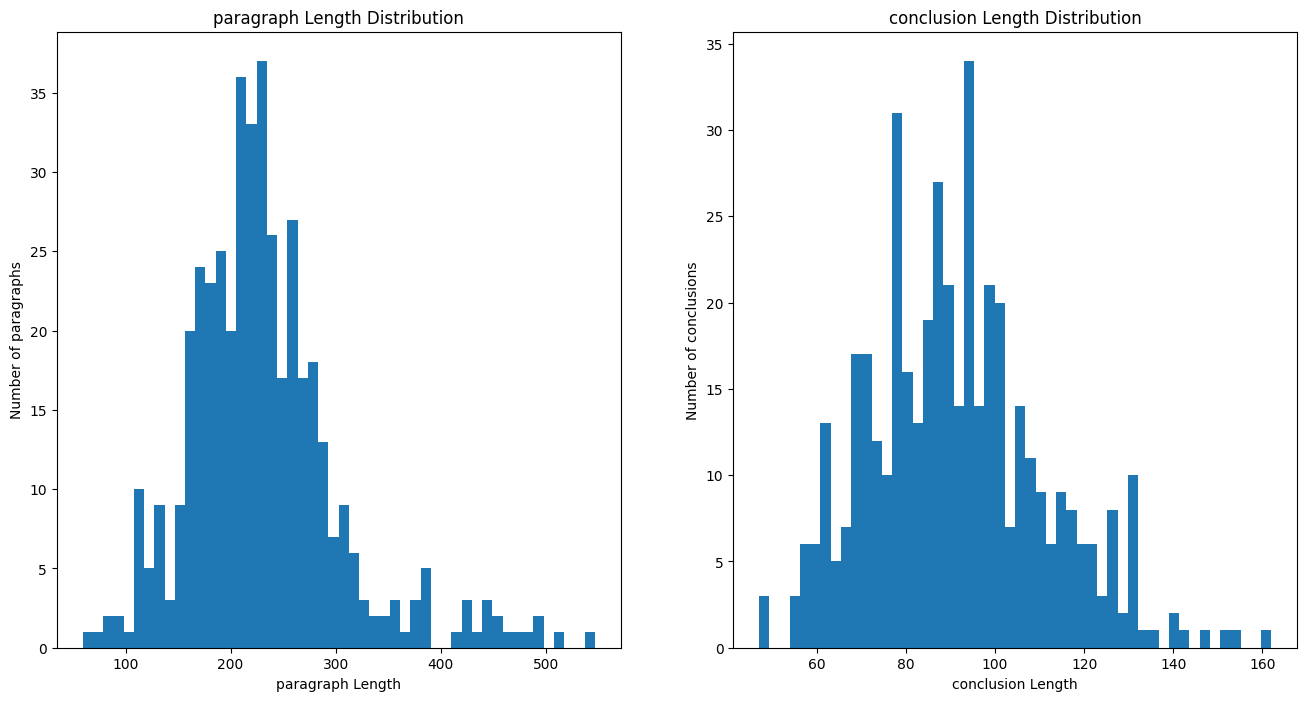

90 th percentile [paragraphS] is  310.40000000000003
91 th percentile [paragraphS] is  314.76
92 th percentile [paragraphS] is  323.36
93 th percentile [paragraphS] is  343.7600000000002
94 th percentile [paragraphS] is  360.03999999999985
95 th percentile [paragraphS] is  379.79999999999995
96 th percentile [paragraphS] is  389.12
97 th percentile [paragraphS] is  424.76000000000005
98 th percentile [paragraphS] is  449.67999999999984
99 th percentile [paragraphS] is  479.2399999999998


90 th percentile [conclusions] is  118.40000000000003
91 th percentile [conclusions] is  120.0
92 th percentile [conclusions] is  121.12
93 th percentile [conclusions] is  123.0
94 th percentile [conclusions] is  126.0
95 th percentile [conclusions] is  127.0
96 th percentile [conclusions] is  130.0
97 th percentile [conclusions] is  130.0
98 th percentile [conclusions] is  132.55999999999995
99 th percentile [conclusions] is  142.27999999999997


(array([[  50,    8,    5, ...,    0,    0,    0],
        [ 674,  183,    1, ...,    0,    0,    0],
        [  12, 1137,  102, ...,    0,    0,    0],
        ...,
        [ 578,  608, 1332, ...,    0,    0,    0],
        [   5,  587,   87, ...,    0,    0,    0],
        [ 235,  454,    1, ...,    0,    0,    0]]),
 array([[  12,   37,    8, ...,    0,    0,    0],
        [  12,  343,  153, ...,    0,    0,    0],
        [  12,    2, 2179, ...,    0,    0,    0],
        ...,
        [  12,    6,   24, ...,    0,    0,    0],
        [  12,    6,   24, ...,    0,    0,    0],
        [  12,    6,   24, ...,    0,    0,    0]]),
 <keras.preprocessing.text.Tokenizer at 0x29a18a80b80>)

In [11]:
process_dataset(
            'data/conclusion/',
            'weights/conclusion/TOKENIZER_FACTS_MODEL_PARAGRAPHS.pkl',
            'weights/conclusion/TOKENIZER_FACTS_MODEL_CONCLUTIONS.pkl',
            )

In [12]:
def encoder(max_x_len, x_voc_size):
    encoder_inputs = tf.keras.layers.Input(shape=(max_x_len,))
    enc_emb = tf.keras.layers.Embedding(x_voc_size, 300, mask_zero=True)(encoder_inputs)
    encoder_lstm = tf.keras.layers.LSTM(300, return_sequences=True, return_state=True)
    encoder_output, state_h, state_c = encoder_lstm(enc_emb)
    encoder_states = [state_h, state_c]
    return encoder_inputs, encoder_states

def decoder(max_y_len, y_voc_size, encoder_states):
    decoder_inputs = tf.keras.layers.Input(shape=(None,))
    dec_emb_layer = tf.keras.layers.Embedding(y_voc_size, 300, mask_zero=True)
    dec_emb = dec_emb_layer(decoder_inputs)
    decoder_lstm = tf.keras.layers.LSTM(300, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
    decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(y_voc_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)
    return decoder_inputs, decoder_outputs

def seq2seq(max_x_len, x_voc_size, max_y_len, y_voc_size):
    encoder_inputs, encoder_states = encoder(max_x_len, x_voc_size)
    decoder_inputs, decoder_outputs = decoder(max_y_len, y_voc_size, encoder_states)
    model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model


def train(                   
        file_dir,
        tokenizer_path_paragraphs,
        tokenizer_path_conclusions,
        summarization_model_path
        ):
    
    paragraphs, conclusions, tokenizer_paragraphs, tokenizer_summarize = process_dataset(file_dir, tokenizer_path_paragraphs, tokenizer_path_conclusions)
    max_x_len = paragraphs.shape[1]
    max_y_len = conclusions.shape[1]
    x_voc_size = len(tokenizer_paragraphs.word_index) + 1
    y_voc_size = len(tokenizer_summarize.word_index) + 1

    model = seq2seq(max_x_len, x_voc_size, max_y_len, y_voc_size)

    call_bactks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

    model.compile(
                optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=[
                        'accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()
                        ])
    model.summary()

    model.fit(
            [paragraphs, conclusions[:,:-1]], 
            tf.keras.utils.to_categorical(conclusions.reshape(conclusions.shape[0], conclusions.shape[1], 1)[:,1:]), 
            batch_size=12, 
            epochs=1000,
            callbacks=[call_bactks]
            )
    
    model.save(summarization_model_path)

C:\Users\Senith\AppData\Local\Temp\ipykernel_31868\1797763986.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(file_dir + file))
C:\Users\Senith\AppData\Local\Temp\ipykernel_31868\1797763986.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(file_dir + file))


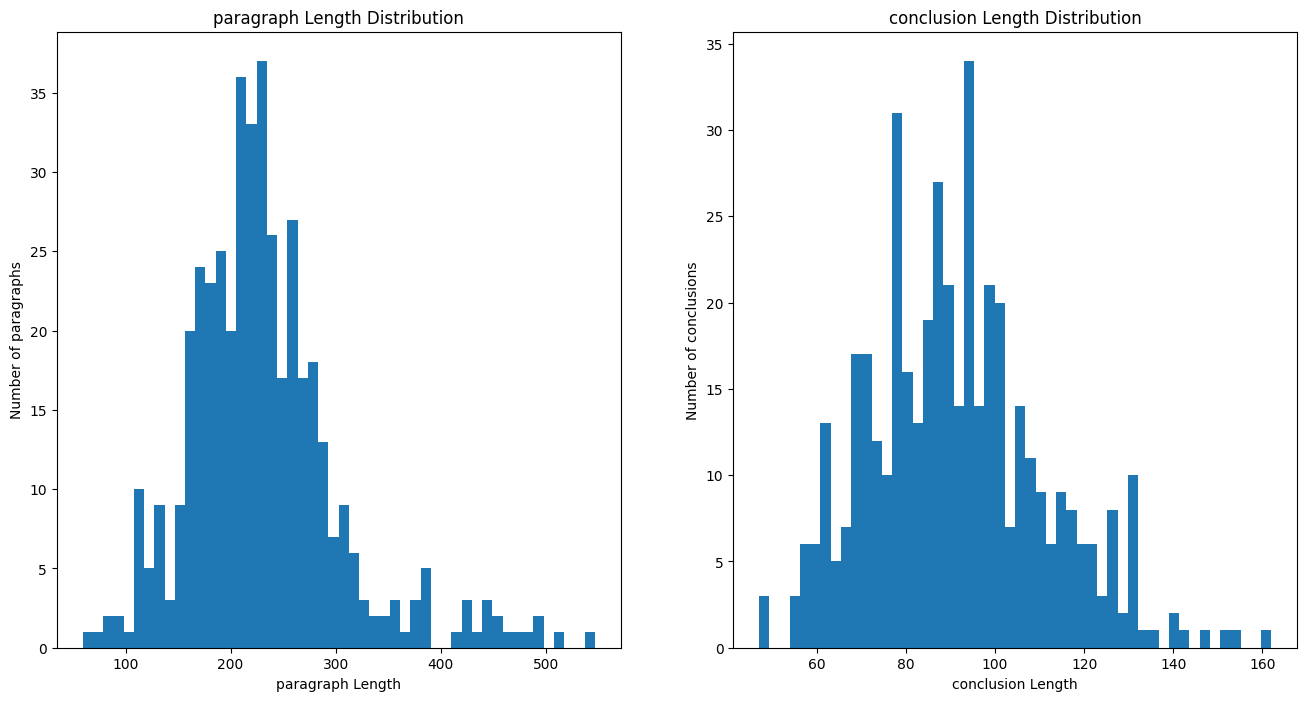

90 th percentile [paragraphS] is  310.40000000000003
91 th percentile [paragraphS] is  314.76
92 th percentile [paragraphS] is  323.36
93 th percentile [paragraphS] is  343.7600000000002
94 th percentile [paragraphS] is  360.03999999999985
95 th percentile [paragraphS] is  379.79999999999995
96 th percentile [paragraphS] is  389.12
97 th percentile [paragraphS] is  424.76000000000005
98 th percentile [paragraphS] is  449.67999999999984
99 th percentile [paragraphS] is  479.2399999999998


90 th percentile [conclusions] is  118.40000000000003
91 th percentile [conclusions] is  120.0
92 th percentile [conclusions] is  121.12
93 th percentile [conclusions] is  123.0
94 th percentile [conclusions] is  126.0
95 th percentile [conclusions] is  127.0
96 th percentile [conclusions] is  130.0
97 th percentile [conclusions] is  130.0
98 th percentile [conclusions] is  132.55999999999995
99 th percentile [conclusions] is  142.27999999999997
Model: "model_3"
_______________________________________

KeyboardInterrupt: 

In [29]:
train(
    'data/conclusion/',
    'weights/conclusion/TOKENIZER_FACTS_MODEL_PARAGRAPHS.pkl',
    'weights/conclusion/TOKENIZER_FACTS_MODEL_CONCLUTIONS.pkl',
    'weights/conclusion/CONCLUTION_GENERATION_MODEL.h5'
    )

# INFERENCE

In [21]:
text = 'Supply chain refers to the network of organizations, .'

In [22]:
tokenizer_path_paragraphs = 'weights/conclusion/TOKENIZER_FACTS_MODEL_PARAGRAPHS.pkl'
tokenizer_path_conclusions = 'weights/conclusion/TOKENIZER_FACTS_MODEL_CONCLUTIONS.pkl'
conclution_generation_model_path = 'weights/conclusion/CONCLUTION_GENERATION_MODEL.h5'

with open(tokenizer_path_paragraphs, 'rb') as handle:
    tokenizer_paragraphs = pickle.load(handle)

with open(tokenizer_path_conclusions, 'rb') as handle:
    tokenizer_conclusions = pickle.load(handle)

encoder_inputs, encoder_states = encoder(500, len(tokenizer_paragraphs.word_index) + 1)
decoder_inputs, decoder_outputs = decoder(150, len(tokenizer_conclusions.word_index) + 1, encoder_states)
inference_model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
inference_model.load_weights(conclution_generation_model_path)

In [23]:
def inference_conclution_generation(
                                    input_text,
                                    max_x_len = 500,
                                    max_y_len = 150
                                    ):

    input_text = tokenizer_paragraphs.texts_to_sequences([input_text])
    input_text = tf.keras.preprocessing.sequence.pad_sequences(input_text, maxlen=max_x_len, padding='post')

    conclusion = np.zeros((1, max_y_len))
    conclusion[0,0] = tokenizer_conclusions.word_index['sostok']
    stop_condition = False
    i = 1
    while not stop_condition:
        preds = inference_model.predict([input_text, conclusion], verbose=0)
        pred = np.argmax(preds[0,i-1])
        conclusion[0,i] = pred
        i += 1
        if pred == tokenizer_conclusions.word_index['eostok'] or i >= max_y_len:
            stop_condition = True

    conclusion = conclusion[0]
    new_conclusion = []
    for i in conclusion:
        if i != 0:
            new_conclusion.append(i)
    conclusion = ' '.join([tokenizer_conclusions.index_word[i] for i in new_conclusion])
    conclusion = conclusion.replace('eostok', '').replace('sostok', '').strip()
    return conclusion

In [24]:
conclusion_facts = inference_conclution_generation(text)
conclusion_facts

'in conclusion, developing a crucial concern for businesses in the flow of goods and services are delivered, organizations can reach their target audiences more effectively and efficiently. however, as digital transformation has become even more important. the need for a comprehensive view of identity management and the role played by employees in restoring trust and confidence in the banking sector.'

# PART 02

### Image Scraping

In [11]:
def scraping_references(search_item):
    df = get_entire_web_google_results(search_item)
    image_urls = df['image_url'].tolist()
    image_urls = [i for i in image_urls if i != '']
    image_urls = [i for i in image_urls if 'logo' not in i]
    return image_urls

In [13]:
search_item = '''At the most fundamental level, supply chain management (SCM) is management of the flow of goods, data, and finances related to a product or service, from the procurement of raw materials to the delivery of the product at its final destination,''' 
image_urls = scraping_references(search_item)
image_urls

['https://www.investopedia.com/thmb/vnaqLiASyVjo1zV-oRL8ABF9mlE=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/scm.asp-ADD-SOURCE-08b7e84e41a34ce18703eaadf947e055.png',
 'https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/msc/ul/g/78/16/781624a8-71b6-490f-ab90c852361760df.jpg/_jcr_content/renditions/cq5dam.web.1280.1280.jpeg',
 'https://www.netsuite.com/portal/assets/img/business-articles/inventory-management/social-what-are-inventory-management-controls.jpg',
 'https://www.netsuite.com/portal/assets/img/business-articles/inventory-management/social-inbound-outbound-logistics.jpg',
 'https://ars.els-cdn.com/content/image/3-s2.0-B9780323898249000070-f07-05-9780323898249.jpg']